In [25]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, GaussianNoise
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [26]:
data = pd.read_csv("/Users/kimjuhwan/Desktop/data/WISDM.csv")

In [27]:
data_jogging = data[data['activity'] == 'Jogging']
data_jogging

,Unnamed: 0,user-id,activity,timestamp,X,Y,Z
0,0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...,...
1080753,1080754,19,Jogging,130447441469000,-7.010000,-10.530000,0.570000
1080754,1080755,19,Jogging,130447481508000,-6.360000,-3.910000,-0.420000
1080755,1080756,19,Jogging,130447521547000,-11.260000,3.020000,1.570000
1080756,1080757,19,Jogging,130447561678000,-17.540000,4.670000,3.980000


In [28]:
data_sitting = data[data['activity'] == 'Sitting']
data_sitting

,Unnamed: 0,user-id,activity,timestamp,X,Y,Z
221333,221333,27,Sitting,12363992261000,2.60,9.66,1.035146
221334,221334,27,Sitting,12364042279000,2.68,9.53,0.503953
221335,221335,27,Sitting,12364092267000,3.49,8.89,0.762740
221336,221336,27,Sitting,12364142316000,3.64,9.38,0.926184
221337,221337,27,Sitting,12364192273000,2.91,9.34,1.035146
...,...,...,...,...,...,...,...
1098198,1098199,19,Sitting,131623331483000,9.00,-1.57,1.690000
1098199,1098200,19,Sitting,131623371431000,9.04,-1.46,1.730000
1098200,1098201,19,Sitting,131623411592000,9.08,-1.38,1.690000
1098201,1098202,19,Sitting,131623491487000,9.00,-1.46,1.730000


In [29]:
Jogging = data_jogging.head(4500).copy()
Sitting = data_sitting.head(4500).copy()

In [30]:
data2 = pd.concat([Jogging, Sitting])
data2.shape

(9000, 7)

In [31]:
del data2['Unnamed: 0']

In [32]:
data2 = data2.rename(columns={'activity': 'Label'})

In [33]:
data2['Label'] = data2['Label'].replace('Sitting', 0)
data2['Label'] = data2['Label'].replace('Jogging', 1)

In [34]:
data2

,user-id,Label,timestamp,X,Y,Z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
255294,36,0,14927622266000,-4.330000,-2.180000,8.308413
255295,36,0,14927672254000,-4.370000,-2.220000,8.349273
255296,36,0,14927722272000,-4.290000,-2.220000,8.308413
255297,36,0,14927772199000,-4.290000,-2.220000,8.281172


In [35]:
del data2['user-id']
del data2['timestamp']

In [36]:
data2

,Label,X,Y,Z
0,1,-0.694638,12.680544,0.503953
1,1,5.012288,11.264028,0.953424
2,1,4.903325,10.882658,-0.081722
3,1,-0.612916,18.496431,3.023717
4,1,-1.184970,12.108489,7.205164
...,...,...,...,...
255294,0,-4.330000,-2.180000,8.308413
255295,0,-4.370000,-2.220000,8.349273
255296,0,-4.290000,-2.220000,8.308413
255297,0,-4.290000,-2.220000,8.281172


In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data2['Label'] = le.fit_transform(data2['Label'])

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data2, test_size=0.25, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6750, 4)
Test shape: (2250, 4)


In [39]:
#Normal = 0, adnormal = 1
normal = X_train[X_train['Label'] == 0]

y_train = normal['Label']
X_train_normal_train = normal.drop(['Label'], axis=1)

y_test = X_test['Label']

X_train_ft = X_train_normal_train.values
X_test = X_test.values

X_train.shape
X_test.shape

(2250, 4)

In [40]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [42]:
def denoising_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='tanh',
                   activity_regularizer=regularizers.l1(10e-5))(input_layer)
    
    encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
    decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    return autoencoder

In [43]:
def add_noise(data, noise_factor=0.5):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return data

In [45]:
noisy_data = add_noise(X_train)

In [47]:
autoencoder = denoising_autoencoder(input_dim, encoding_dim)

In [48]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(noisy_data, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
211/211 [==============================] - 1s 2ms/step - loss: 30.7768 - accuracy: 0.8012 - val_loss: 25.7855 - val_accuracy: 0.8763
Epoch 2/10
211/211 [==============================] - 0s 858us/step - loss: 22.4313 - accuracy: 0.8695 - val_loss: 19.7714 - val_accuracy: 0.8904
Epoch 3/10
211/211 [==============================] - 0s 884us/step - loss: 17.9474 - accuracy: 0.8879 - val_loss: 16.8021 - val_accuracy: 0.9111
Epoch 4/10
211/211 [==============================] - 0s 844us/step - loss: 15.7297 - accuracy: 0.8984 - val_loss: 14.9435 - val_accuracy: 0.9170
Epoch 5/10
211/211 [==============================] - 0s 850us/step - loss: 14.0798 - accuracy: 0.8996 - val_loss: 12.8838 - val_accuracy: 0.9148
Epoch 6/10
211/211 [==============================] - 0s 842us/step - loss: 11.7794 - accuracy: 0.9047 - val_loss: 11.1994 - val_accuracy: 0.9422
Epoch 7/10
211/211 [==============================] - 0s 864us/step - loss: 10.6790 - accuracy: 0.9412 - val_loss: 10.3794 - v

In [49]:
autoencoder = load_model('model.h5')

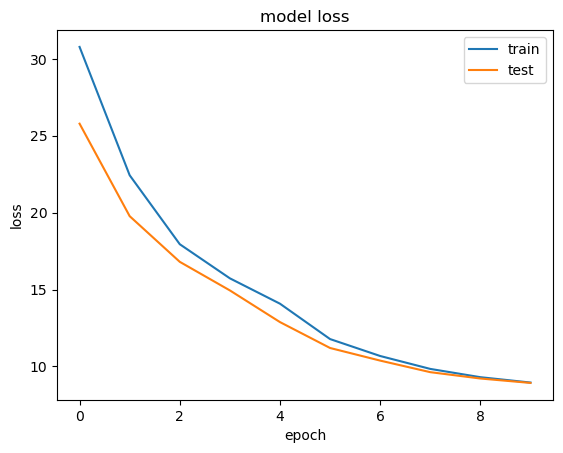

In [50]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [51]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 478us/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,9.035332,0.496889
std,11.917795,0.500101
min,0.017951,0.000000
25%,2.275170,0.000000
50%,5.878919,0.000000
75%,8.401763,1.000000
max,110.166412,1.000000


In [52]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [53]:
threshold = 1.9

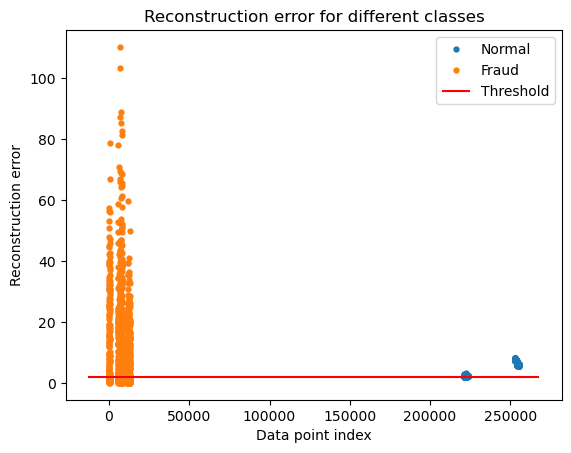

In [54]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

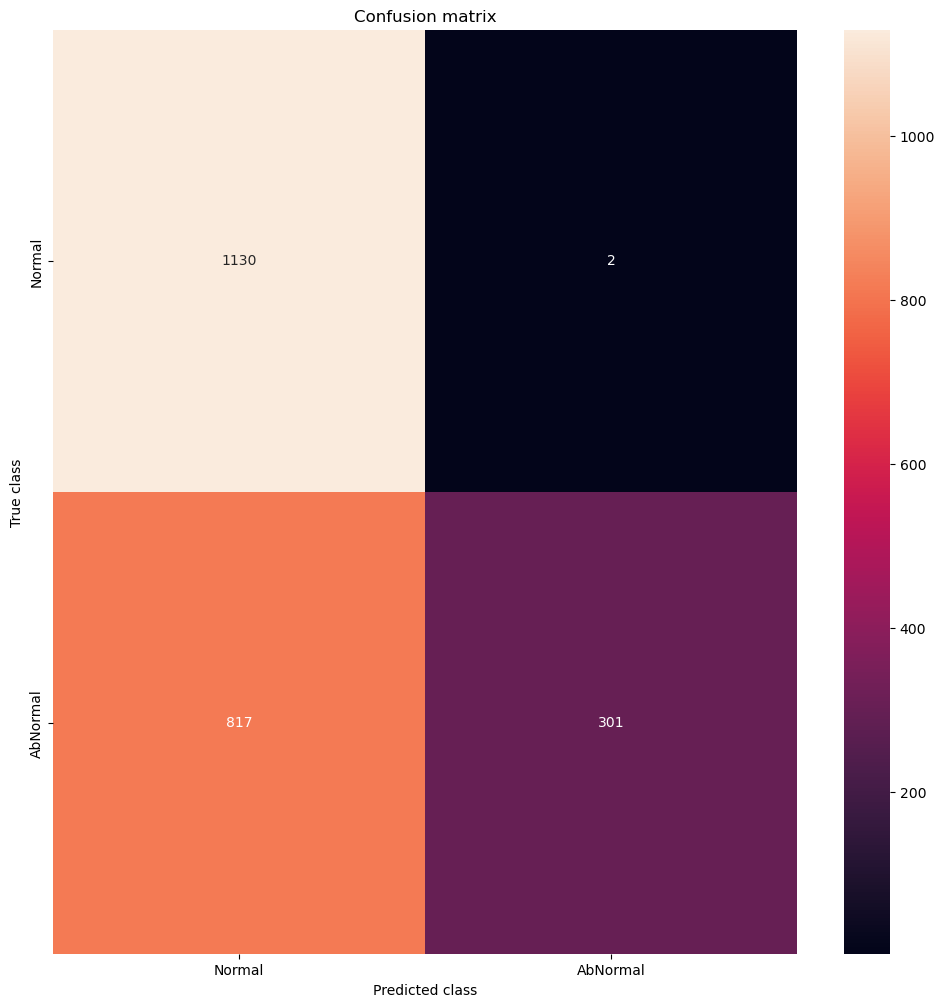

In [55]:
LABELS = ["Normal", "AbNormal"]



y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [56]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.636
Precision : 0.9933993399339934
Recall : 0.2692307692307692
F1 : 0.4236453201970443
